# Formula 1 Lap Time Prediction

<img src="images/donut.jpg">

The datasets provided are generated from Formula One races spanning 1996 through 2023. The goal is to predict the time required for drivers to complete laps on various circuits. Rows represent individual driver laps, and columns provide a set of descriptive features.

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_column', 100)

In [192]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

## EDA - Exploratory Data Analysis

In [193]:
df_train.head()

,id,race,date,time,circuit,latitude,longitude,altitude,driver,carNumber,constructor,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitStop,pitCount,pitTime_ms,lapTime_ms
0,1,British Grand Prix,2017-07-16,12:00:00,Silverstone Circuit,52.0786,-1.01694,153,"Ricciardo, Daniel",3,Red Bull,9.799145,3.033426,18,10,0,0,0.0,94846
1,2,Australian Grand Prix,2023-04-02,05:00:00,Albert Park Grand Prix Circuit,-37.8497,144.96800,10,"Hülkenberg, Nico",27,Haas F1 Team,12.418502,7.871795,13,7,0,1,0.0,83719
2,3,Mexican Grand Prix,2019-10-27,19:10:00,Autódromo Hermanos Rodríguez,19.4042,-99.09070,2227,"Magnussen, Kevin",20,Haas F1 Team,13.808140,7.871795,46,16,0,1,0.0,82213
3,4,United States Grand Prix,2000-09-24,NaN,Indianapolis Motor Speedway,39.7950,-86.23470,223,"Mazzacane, Gastón",21,Minardi,21.468750,10.394659,42,13,0,0,0.0,76951
4,5,Hungarian Grand Prix,2011-07-31,12:00:00,Hungaroring,47.5789,19.24860,264,"d'Ambrosio, Jérôme",25,Virgin,21.518519,11.736842,48,19,0,3,0.0,151214


In [194]:
df_train.shape

(30000, 19)

In [195]:
df_test.shape

(20714, 18)

In [196]:
#concatenate train and test data
df = pd.concat([df_train, df_test], axis=0)

In [197]:
df.isnull().sum()

id                          0
race                        0
date                        0
time                    11872
circuit                     0
latitude                    0
longitude                   0
altitude                    0
driver                      0
carNumber                   0
constructor                 0
avgDriverFinish             0
avgConstructorFinish        0
lapNumber                   0
lapPosition                 0
pitStop                     0
pitCount                    0
pitTime_ms                  0
lapTime_ms              20714
dtype: int64

In [198]:
# drop time column
df.drop('time', axis=1, inplace=True)

In [199]:
df.describe()

,id,latitude,longitude,altitude,carNumber,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitStop,pitCount,pitTime_ms,lapTime_ms
count,50714.000000,50714.000000,50714.000000,50714.000000,50714.000000,50714.000000,50714.000000,50714.000000,50714.000000,50714.000000,50714.000000,5.071400e+04,3.000000e+04
mean,25357.500000,34.619460,6.241621,341.484403,19.377430,10.995776,5.607739,29.955279,9.709922,0.022933,0.744055,3.001856e+03,9.445979e+04
std,14640.015113,22.121087,65.791315,503.285771,20.178558,4.706612,2.379248,18.289940,5.556325,0.149690,1.019343,6.557303e+04,6.375514e+04
min,1.000000,-37.849700,-99.090700,-7.000000,1.000000,2.711180,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,6.620000e+04
25%,12679.250000,30.132800,-8.626700,45.000000,7.000000,7.448925,3.033426,14.000000,5.000000,0.000000,0.000000,0.000000e+00,8.127850e+04
50%,25357.500000,43.734700,6.947500,162.000000,14.000000,10.140187,5.246659,29.000000,9.000000,0.000000,0.000000,0.000000e+00,9.049250e+04
75%,38035.750000,47.578900,19.248600,401.000000,22.000000,13.823529,7.268041,44.000000,14.000000,0.000000,1.000000,0.000000e+00,1.004710e+05
max,50714.000000,52.388800,144.968000,2227.000000,99.000000,25.052632,11.736842,78.000000,24.000000,1.000000,6.000000,2.077164e+06,2.253574e+06


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50714 entries, 0 to 20713
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    50714 non-null  int64  
 1   race                  50714 non-null  object 
 2   date                  50714 non-null  object 
 3   circuit               50714 non-null  object 
 4   latitude              50714 non-null  float64
 5   longitude             50714 non-null  float64
 6   altitude              50714 non-null  int64  
 7   driver                50714 non-null  object 
 8   carNumber             50714 non-null  int64  
 9   constructor           50714 non-null  object 
 10  avgDriverFinish       50714 non-null  float64
 11  avgConstructorFinish  50714 non-null  float64
 12  lapNumber             50714 non-null  int64  
 13  lapPosition           50714 non-null  int64  
 14  pitStop               50714 non-null  int64  
 15  pitCount           

In [201]:
df['lapTime_s'] = df['lapTime_ms'] / 1000

print(df[['lapTime_ms', 'lapTime_s']].head())


   lapTime_ms  lapTime_s
0     94846.0     94.846
1     83719.0     83.719
2     82213.0     82.213
3     76951.0     76.951
4    151214.0    151.214


# Data Visualization

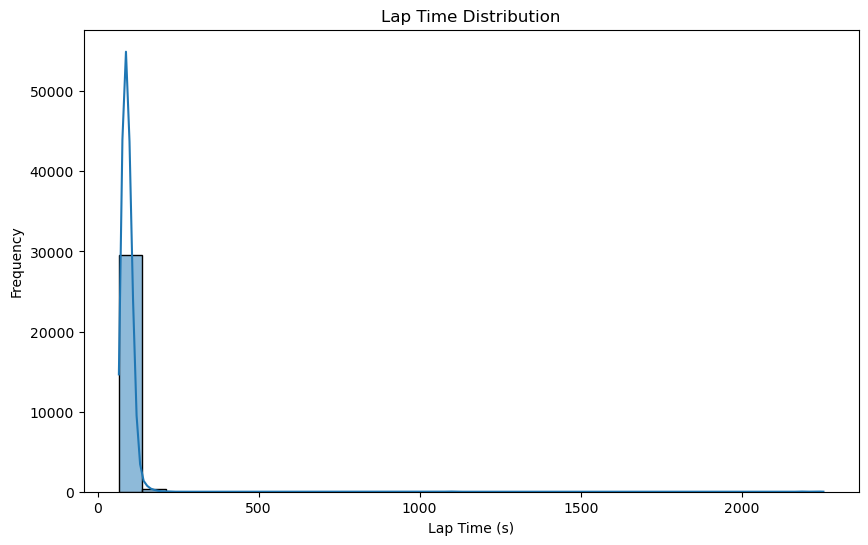

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['lapTime_s'], bins=30, kde=True)
plt.title('Lap Time Distribution')
plt.xlabel('Lap Time (s)')
plt.ylabel('Frequency')
plt.show()

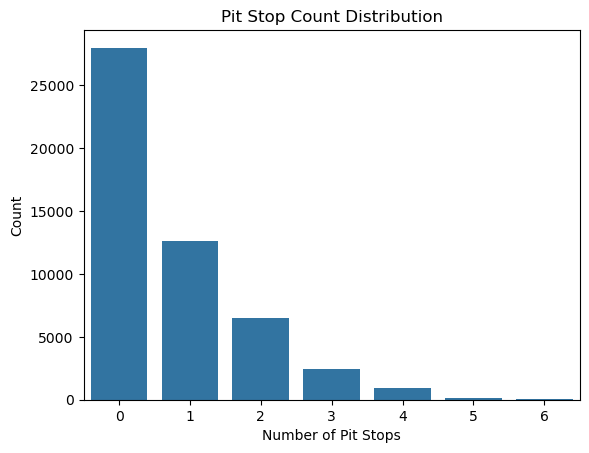

In [203]:
sns.countplot(x='pitCount', data=df)
plt.title('Pit Stop Count Distribution')
plt.xlabel('Number of Pit Stops')
plt.ylabel('Count')
plt.show()


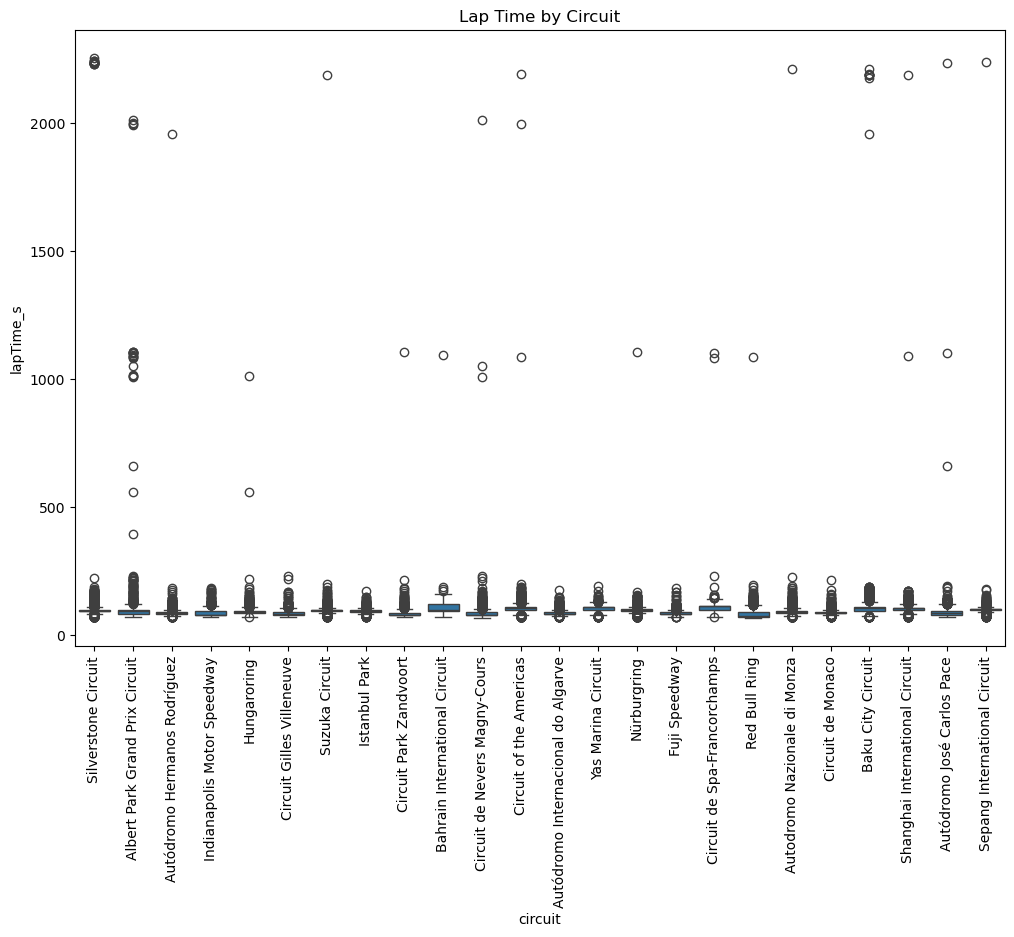

In [204]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='circuit', y='lapTime_s', data=df)
plt.xticks(rotation=90)
plt.title('Lap Time by Circuit')
plt.show()


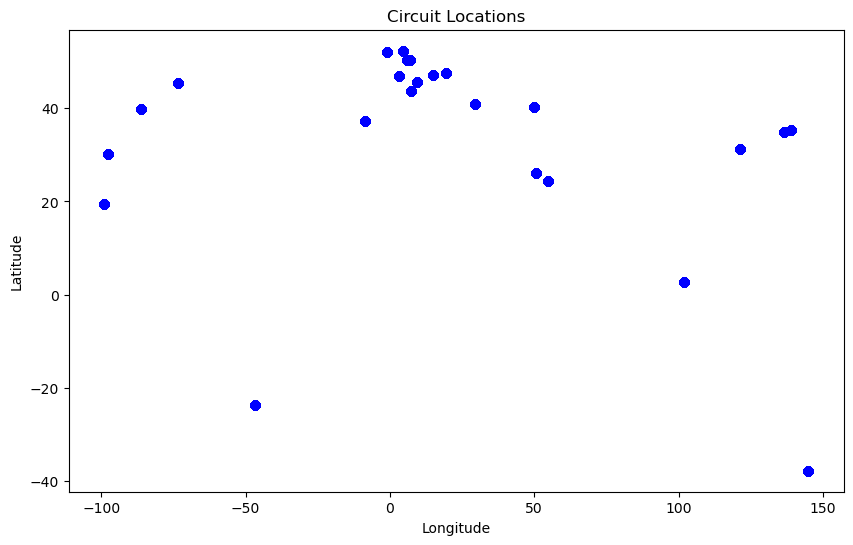

In [205]:
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], c='blue')
plt.title('Circuit Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


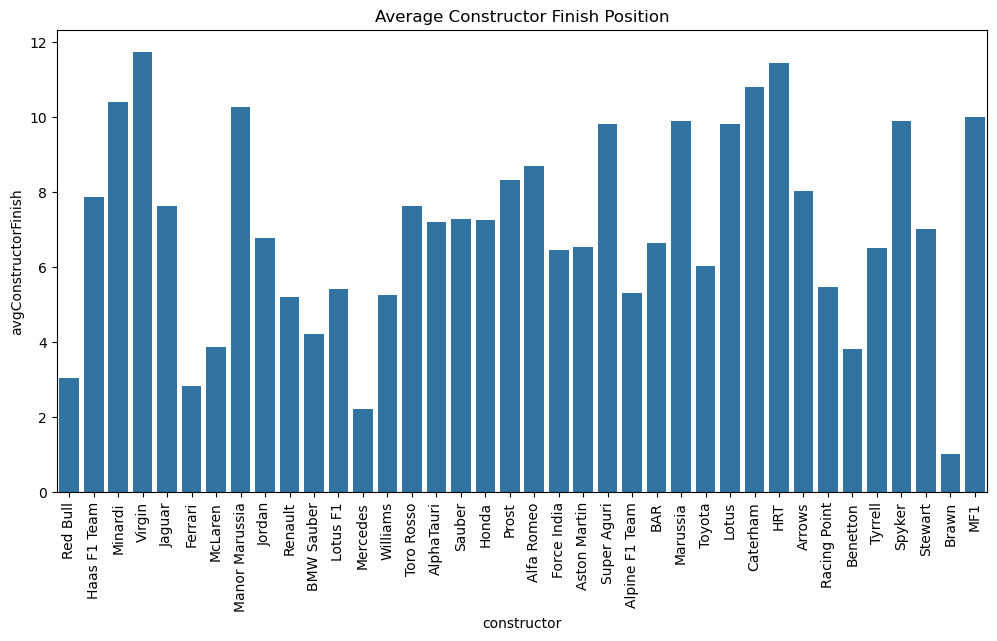

In [206]:
plt.figure(figsize=(12, 6))
sns.barplot(x='constructor', y='avgConstructorFinish', data=df)
plt.xticks(rotation=90)
plt.title('Average Constructor Finish Position')
plt.show()


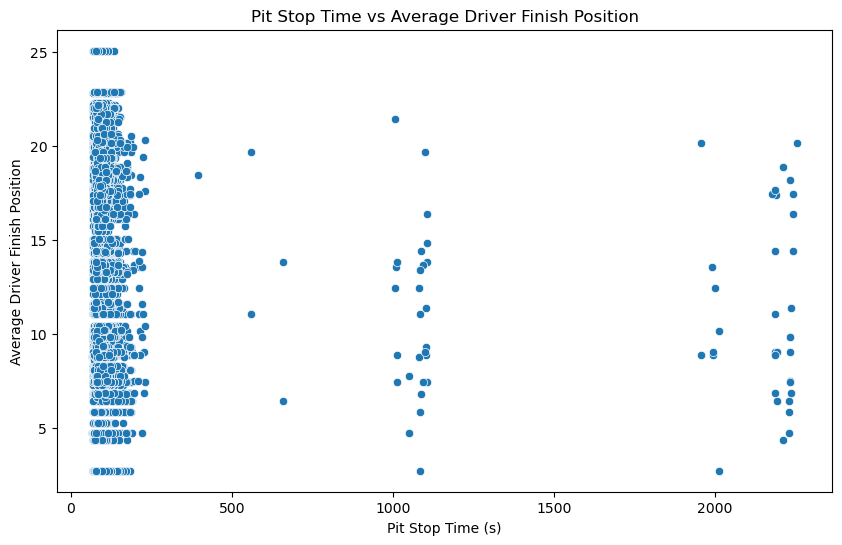

In [207]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lapTime_s', y='avgDriverFinish', data=df)
plt.title('Pit Stop Time vs Average Driver Finish Position')
plt.xlabel('Pit Stop Time (s)')
plt.ylabel('Average Driver Finish Position')
plt.show()


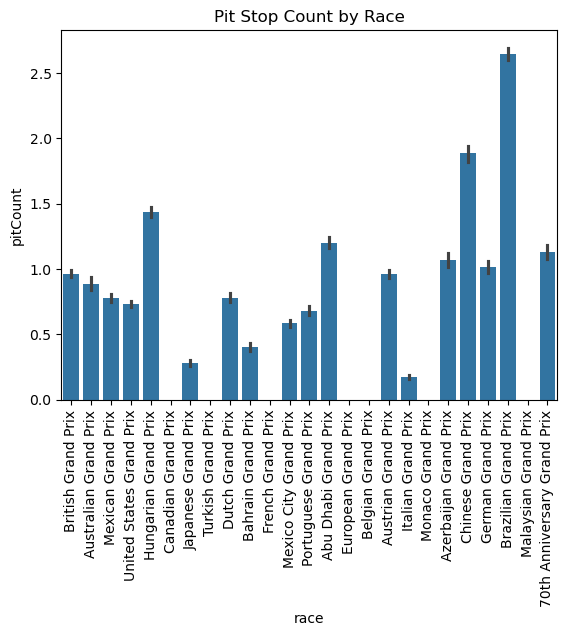

In [208]:
sns.barplot(x='race', y='pitCount', data=df)
plt.xticks(rotation=90)
plt.title('Pit Stop Count by Race')
plt.show()


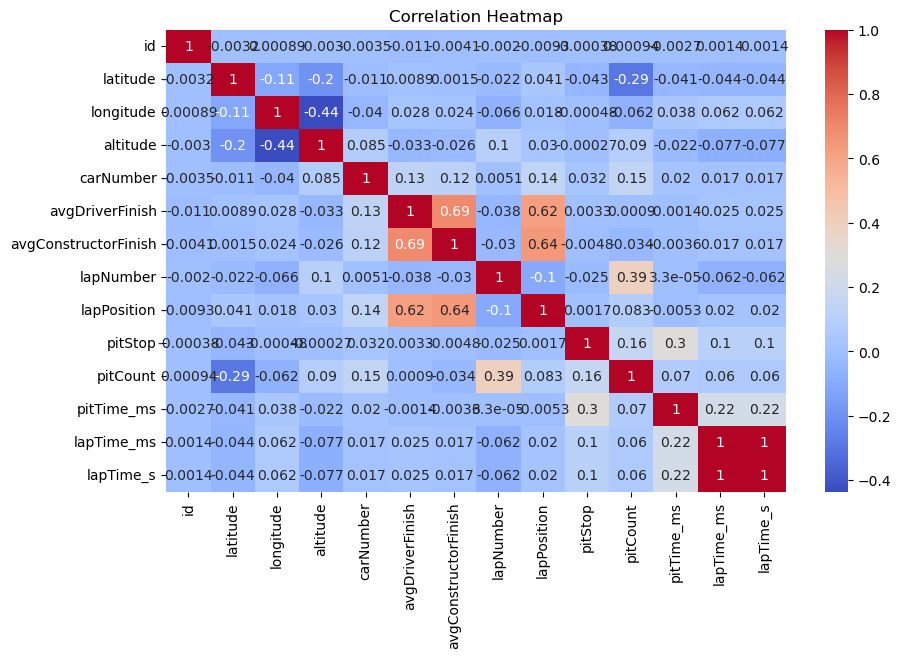

In [209]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## Feature Engineering

In [210]:
# date to year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df.drop('date', axis=1, inplace=True)


In [211]:
df.head()

,id,race,circuit,latitude,longitude,altitude,driver,carNumber,constructor,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitStop,pitCount,pitTime_ms,lapTime_ms,lapTime_s,year
0,1,British Grand Prix,Silverstone Circuit,52.0786,-1.01694,153,"Ricciardo, Daniel",3,Red Bull,9.799145,3.033426,18,10,0,0,0.0,94846.0,94.846,2017
1,2,Australian Grand Prix,Albert Park Grand Prix Circuit,-37.8497,144.96800,10,"Hülkenberg, Nico",27,Haas F1 Team,12.418502,7.871795,13,7,0,1,0.0,83719.0,83.719,2023
2,3,Mexican Grand Prix,Autódromo Hermanos Rodríguez,19.4042,-99.09070,2227,"Magnussen, Kevin",20,Haas F1 Team,13.808140,7.871795,46,16,0,1,0.0,82213.0,82.213,2019
3,4,United States Grand Prix,Indianapolis Motor Speedway,39.7950,-86.23470,223,"Mazzacane, Gastón",21,Minardi,21.468750,10.394659,42,13,0,0,0.0,76951.0,76.951,2000
4,5,Hungarian Grand Prix,Hungaroring,47.5789,19.24860,264,"d'Ambrosio, Jérôme",25,Virgin,21.518519,11.736842,48,19,0,3,0.0,151214.0,151.214,2011


In [212]:
df.columns

Index(['id', 'race', 'circuit', 'latitude', 'longitude', 'altitude', 'driver',
       'carNumber', 'constructor', 'avgDriverFinish', 'avgConstructorFinish',
       'lapNumber', 'lapPosition', 'pitStop', 'pitCount', 'pitTime_ms',
       'lapTime_ms', 'lapTime_s', 'year'],
      dtype='object')

In [213]:
df = df[['latitude', 'longitude', 'altitude', 'driver', 'constructor', 
        'avgDriverFinish', 'avgConstructorFinish', 'lapNumber', 
        'lapPosition', 'pitStop', 'pitCount', 'pitTime_ms', 'year', 'lapTime_ms']]

In [214]:
df = pd.get_dummies(df, drop_first=True)

In [216]:
# train and test data
train = df[df.lapTime_ms.notnull()]
test = df[df.lapTime_ms.isnull()].drop(['lapTime_ms'], axis=1)

In [217]:
x = train.drop('lapTime_ms', axis=1)
y = train['lapTime_ms']

In [218]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, ExtraTreeRegressor
#pip install xgboost
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

from sklearn.preprocessing import StandardScaler


def algo_test(x,y):
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        sgd=SGDRegressor()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        rkn=RadiusNeighborsRegressor(radius=1.0)
        ada=AdaBoostRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        svr=SVR()
        mlp_regressor = MLPRegressor()

       
        
        algos=[L,R,Lass,E,sgd,ETR,GBR,ada,kn,dt,xgb,svr,mlp_regressor]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','SGD','Extra Tree','Gradient Boosting',
                    'KNeighborsRegressor','AdaBoost','Decision Tree','XGBRegressor','SVR','mlp_regressor']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.20,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
        
            

        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [64]:
algo_test(x_scaled,y)

,R_Squared,RMSE,MAE
XGBRegressor,8.457929e-01,2.655779e+01,3.711607e+00
KNeighborsRegressor,5.241622e-01,4.665189e+01,1.366247e+01
Gradient Boosting,4.428979e-01,5.047858e+01,7.346122e+00
mlp_regressor,2.417349e-01,5.889118e+01,1.052397e+01
AdaBoost,1.346210e-01,6.291337e+01,6.062652e+00
Ridge,8.205046e-02,6.479614e+01,1.330170e+01
Linear,8.201422e-02,6.479742e+01,1.329878e+01
Lasso,8.090362e-02,6.483661e+01,1.343977e+01
ElasticNet,6.933902e-02,6.524324e+01,1.326818e+01
SVR,1.392202e-02,6.715763e+01,1.078103e+01


In [188]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [219]:
xgb=XGBRegressor()
xgb.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [221]:
xgb_pred=xgb.predict(test).flatten()

In [222]:
result = pd.DataFrame({'id': df_test['id'], 'lapTime_ms': xgb_pred})

In [223]:
result.to_csv('submission.csv', index=False)

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [66]:
model = Sequential()
model.add(Dense(120, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [78]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 224.4786 - val_loss: 6776.1826
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 1565.4967 - val_loss: 6406.9932
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 1233.0730 - val_loss: 4843.4419
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 1895.9250 - val_loss: 5257.1211
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 909.3813 - val_loss: 6357.7393
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 718.6891 - val_loss: 6064.7334
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 1543.4222 - val_loss: 4457.0825
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1386.5969 - val_loss: 5518.5376
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 922.9283 - val_loss: 6709.6455
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 905.2723 - val_loss: 4347.1948
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 9

In [79]:
pred = model.predict(x_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


In [80]:
from sklearn.metrics import mean_squared_error, r2_score

In [81]:
r2_score(y_test, pred)

-0.10724821410162022

In [82]:
mean_squared_error(y_test, pred) ** 0.5

71.16430835722913

In [83]:
loss_f = pd.DataFrame(history.history)

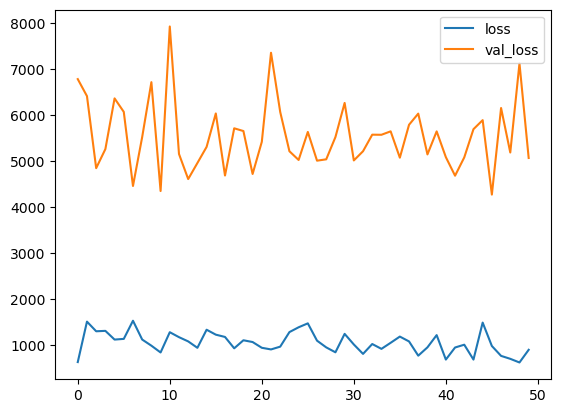

In [84]:
loss_f.plot();